<a href="https://colab.research.google.com/github/tzlilLV97/Task4_Deep_Learning/blob/main/Final_HW4_ALON_TZLIL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Alon Feldman 312213135**

**Tzlil Lev-or 318646510**

# **Assignment 4 - Variational Autoencoders**

In this assignment, we will train a model to produce new human faces with variational autoencoders (VAEs). 
Variational autoencoders let us design complex generative models of data, and fit them to large datasets. They can generate images of fictional celebrity faces (as we'll do in this assignment), high-resolution digital artwork and many more tasks. These models also yield state-of-the-art machine learning results in image generation and reinforcement learning. Variational autoencoders (VAEs) were defined in 2013 by Kingma and Wellings [1].

In this assignment, you will build, train and analyze a VAE with the CelebA dataset. You will analyze how well images can be reconstructed from the lower dimensional representations and try to generate images that look similar to the images in the CelebA dataset.

[1] Kingma, Diederik P., and Max Welling. "Auto-encoding variational bayes." arXiv preprint arXiv:1312.6114 (2013). 


# **Section 1: Variational Autoencoders**


Let us recall the structure of the variational autoencoder:

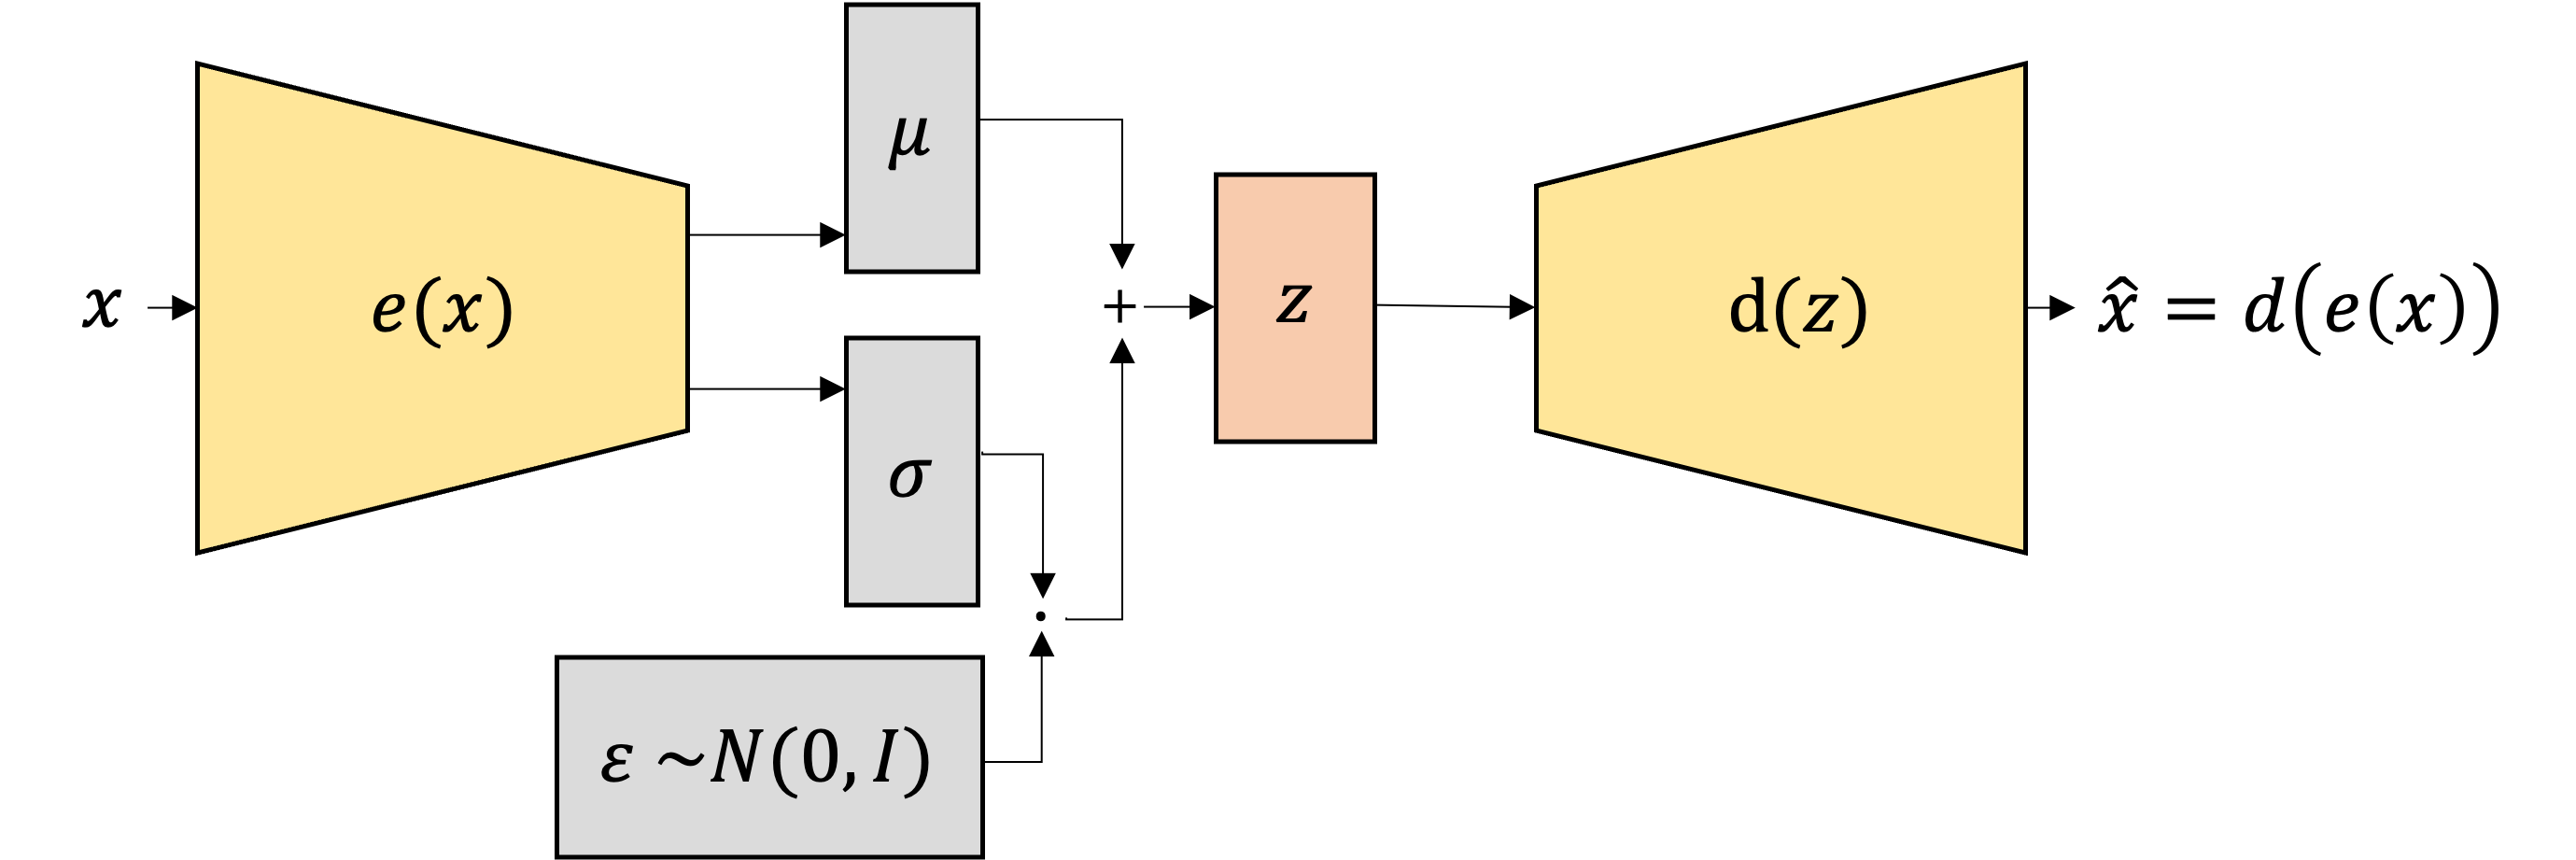

**Imports**

Before we begin, we import the needed libraries. 


You may modify the starter code as you see fit, including changing the signatures of
functions and adding/removing helper functions. However, please make sure that we can understand what you are doing and why.

In [ ]:
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as nnF
from torchvision.utils import make_grid
import torch.utils.data as data_utils
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import torchvision.transforms.functional as F
from torchvision.utils import make_grid
import os
import zipfile

%pip install wget   
import wget

# use GPU for computation if possible: Go to RUNTIME -> CHANGE RUNTIME TYPE -> GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9674 sha256=37f55a8ce785dca28d79db89c65a00a08dba4f89379a60ad37d6bcd1192766f5
  Stored in directory: /root/.cache/pip/wheels/bd/a8/c3/3cf2c14a1837a4e04bd98631724e81f33f462d86a1d895fae0
Successfully built wget


Connect to your Google Drive, select the path in your drive for saving the checkpoints of your model, which we will train later.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

# Path to save the dataset.
PATH_TO_SAVE_MODEL = '/content/gdrive/MyDrive/Colab Notebooks' # TODO - UPDATE ME!

Mounted at /content/gdrive


Define random seeds in order to reproduce your results.

In [ ]:
# TO DO: Set random seeds - to your choice
torch.manual_seed(42)         # Insert any integer
torch.cuda.manual_seed(42)    # Insert any integer

## Question 1. Basic Principles (10 %)




### Part (a) -- 3%

What is the difference between deterministic autoencoder we saw in class and the variational autoencoder? 

In [ ]:
# The main difference between a deterministic autoencoder and a variational autoencoder is
# the way in which the latent representation (Z) is generated. In a deterministic autoencoder, 
# the latent representation is a fixed, deterministic mapping of the input-> Z=f(y).
# This means that if the autoencoder receives the same input multiple times,
# it will always produce the same output.
# In contrast, in a variational autoencoder, the latent representation is a random variable,
# whose distribution is determined by the encoder mapping-> Z~q(*|y).
# This means that if the autoencoder receives the same input multiple times,
# it will produce different outputs, as the latent representation is generated randomly from a distribution.

### Part (b) -- 3%
In which manner Variational Autoencoder is trained? Explain.


In [ ]:
# Variational Auto Encoders are trained using a method called variational inference
# (As we saw in the refferences in the class PDF). 
# This method involves two main components: the reconstruction loss and the KL divergence loss. 
# The reconstruction loss, which is typically calculated using cross entropy, 
# measures the accuracy of the decoder in reconstructing the input data distribution. 
# The KL divergence loss, on the other hand, measures the similarity between the learned 
# probabilistic encoder and the desired marginal distribution of the latent variables. 

# Together, these losses are known as the ELBO loss function, which is mathematically 
# solid but can be difficult to optimize from data. In order to make the KL divergence 
# easier to evaluate, we can use two methods: 

# the Variational Approximation or the Reparameterization Trick. 
# We saw in the first figure of the task, that we would use the Reparameterization Trick, 
# which helps to provide a mathematical and calculable expression for training the VAE. 
# Together, these methods help to optimize the VAE for accurate and efficient encoding and decoding of data.


### Part (c) -- 4%

In class we saw another generative model, known as generative adversarial network (GAN). What are the differences in terms of task objective between GANs and VAEs? Give an example for a task which a VAE is more suitable than GAN, and vice versa.

In [ ]:
# VAEs and GANs are both generative models that can be used to generate new data samples.
# However, they have different objectives and characteristics. VAEs are trained to
# reconstruct the input data and to learn a compact latent representation of the data
# that can be used to generate new samples. On the other hand, GANs are trained to generate
# samples that are indistinguishable from real-world data, but they do not have the same
# reconstruction objective as VAEs.

# VAEs may be more suitable than GANs when you want to generate samples that are 
# similar to the training data, but you also want to be able to control certain 
# aspects of the generated samples. *For example * , you can use a VAE to generate
# images of faces with different attributes by interpolating between latent codes
# that correspond to different attributes. * GANs * may be more suitable than VAEs
# when you want to generate high-quality, realistic samples, or when you want to
# generate a large number of diverse samples.

## Question 2. Data (15 %)

In this assignement we are using the CelebFaces Attributes Dataset (CelebA).

The CelebA dataset, as its name suggests, is comprised of celebrity faces. The images cover large pose variations, background clutter, diverse people, supported by a large quantity of images and rich annotations. This data was originally collected by researchers at MMLAB, The Chinese University of Hong Kong.

**Overall**

- 202,599 number of face images of various celebrities
- 10,177 unique identities, but names of identities are not given
- 40 binary attribute annotations per image
- 5 landmark locations

In this torchvision version of the dataset, each image is in the shape of
$[218,178,3]$ and the values are in $[0,1]$.

Here, you will download the dataset to the Google Colab disk. It is highly recommended not to download the dataset to your own Google Drive account since it is time consuming.

In [ ]:
data_path = "datasets" ## TO DO -- UPDATE ME!

base_url = "https://graal.ift.ulaval.ca/public/celeba/"

file_list = [
    "img_align_celeba.zip",
    "list_attr_celeba.txt",
    "identity_CelebA.txt",
    "list_bbox_celeba.txt",
    "list_landmarks_align_celeba.txt",
    "list_eval_partition.txt",
]
 
# Path to folder with the dataset
dataset_folder = f"{data_path}/celeba"
os.makedirs(dataset_folder, exist_ok=True)

for file in file_list:
    url = f"{base_url}/{file}"
    if not os.path.exists(f"{dataset_folder}/{file}"):
        wget.download(url, f"{dataset_folder}/{file}")

with zipfile.ZipFile(f"{dataset_folder}/img_align_celeba.zip", "r") as ziphandler:
    ziphandler.extractall(dataset_folder)

### Part (a) -- 5%

Apply transformations:

The data is given as PIL (Python Imageing Library) images. Since we are working with PyTorch, we wish to apply transformations to the data in order to process it properly.

Here you should apply transformations to the data. There are many kinds of transformations which can be found here: https://pytorch.org/vision/stable/transforms.html. Note that transformations can be chained together using Compose method.

Think which transformations can be suitable for this task and apply it in the form of: 

trfm = transforms.Compose([transforms.transform1(),transforms.transform2(),...])

We recommend to consider:
- transforms.ToTensor()
- transforms.Resize()

In [ ]:
trfm = transforms.Compose([transforms.ToTensor(),transforms.Resize(size=(218,178))]) # You can add additional transformations which you think could be fit to the data.

training_data = datasets.CelebA(root=data_path, split='train', download=False, transform=trfm)#load the dataset (without download it directly) from our root directory on google drive disk. 
test_data = datasets.CelebA(root=data_path, split='test', download=False, transform=trfm)

In [ ]:
# Training_data is 162,770 celeb in the , each celeb is a tuple:
#  (tensor[C=3,H=218,W=178],tensor[40 binary attribute])
# Test_data is 19,962 celeb- same dataType as training_data
print(len(training_data)) 
print(training_data[0][0].shape) ##EXEPCTED [3,218,178]
print(training_data[0][1].shape) ##EXEPCTED [40]

162770
torch.Size([3, 218, 178])
torch.Size([40])


### Part (b) -- 5%

In order to get in touch with the dataset, and to see what we are dealing with (which is always recommended), we wish to visualize some data samples from the CelebA dataset.

Write a function: show():

INPUT: Python list of length 32 where each element is an image, randomly selected from the training data.

OUTOUT: Showing a 8X4 grid of images.

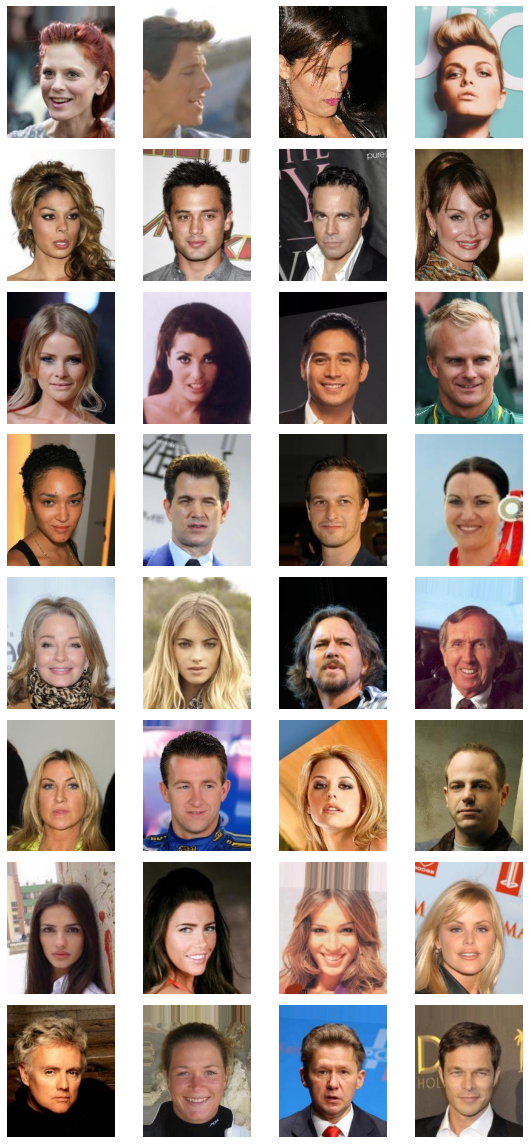

In [ ]:
def show(imgs):
    # your code goes here:
    # INPUT= list of 32 tensor img
    # OUTPUT= 8X4 grid of images
    if len(imgs)!=32:
      print(len(imgs))
      return None
    plt.figure(figsize=(8, 16))

    for idx,celeb in enumerate(imgs):
      plt.subplot(8, 4, idx+1)
      plt.imshow(celeb.permute(1,2,0))
      plt.axis('off')
    plt.tight_layout()
    return None

imgsAsPythonList=[x[0] for x in data_utils.Subset(training_data, torch.arange(1,33))]
show(imgsAsPythonList)

### Part (c) -- 5%

Extrapolate in the image domain:

Here, randomly take 2 images from the training dataset, combine them together and plot the result. For example, consider $X_1$ and $X_2$ to be 2 images randomly taken from the training data. Plot $\alpha\cdot X_1 + (1-\alpha)\cdot X_2$. 

Explain the results, is extrapolation in the image domain reasonable?

Note: Recall that the images should be in the $[0,1]$ interval.

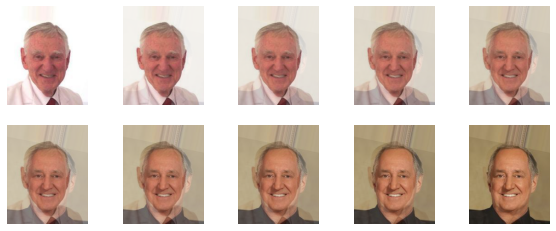

In [ ]:
# Your code goes here
i= random.randint(1,len(training_data))
j=random.randint(1,len(training_data))
plt.figure(figsize=(10, 4)) 
for a in range(10):
  alpha=a/10
  combine_img=alpha*training_data[i][0]+(1-alpha)*training_data[j][0]
  plt.subplot(2, 5, a+1)
  plt.imshow(combine_img.permute(1,2,0))
  plt.axis('off')


In [ ]:
# The results of extrapolation in the image domain are not necessarily reasonable because 
# there is no logical relationship between the two images being combined. 
# The resulting image is simply a combination of two images, with each pixel value 
# being a weighted average of the corresponding pixel values in the two images. 
# When the two images have very different structures or the weights are close to 0 or 1, 
# the resulting image may appear unrealistic or distorted. This is because the pixel values 
# from one image are given a very small weight, making it difficult to distinguish from the other image. 
# In these cases, extrapolation may produce unrealistic or distorted results. 
# It is important to carefully consider the suitability of extrapolation for a given 
# image dataset and to validate the results of extrapolation to ensure that they are reasonable and accurate.

## Question 3. VAE Foundations (15 %)


Let us start by recalling the analytical derivation of the VAE.


The simplest version of VAE is comprised of an encoder-decoder architecture.
The *encoder* is a neural network which its input is a datapoint $x$, its output is a hidden representation $z$, and it has weights and biases $\theta$. We denote the encoder's mapping by $P_{\theta}(z|x)$. The *decoder* is another neural network which its input is the data sample $z$, its output is the reconstructed input $x$, and its parameters $\phi$. Hence, we denote the decoder's mapping by $P_{\phi}(x|z)$.

The goal is to determine a posterior distribution $P_{\theta}(z|x)$ of a latent variable $z$ given some data evidence $x$. However, determining this posterior distribution is typically computationally intractable, because according to Bayes:

$(1)$ $P(z|x) = \frac{P(x|z)P(z)}{P(x)}$

The term $P(x)$ is called the evidence, and we can calculate it by marginalization on the latent variable:

$P(x) = \int_{z}P(x|z)P(z)dz$

Unfortunately, this term is intractable because it requires computation of the integral over the entire latent space $z$. To bypass this intractability problem we approximate the posterior distribution with some other distribution $q(z|x_i)$. This approximation is made by the KL-divergence:

$(2)$ $D_{KL}\big(q(z|x_i)||P(z|x_i)\big) = \int_{z}q(z|x_i)\cdot\log\big(\frac{q(z|x_i)}{P(z|x_i)}\big)dz = -\int_{z}q(z|x_i)\cdot\log\big(\frac{P(z|x_i)}{q(z|x_i)}\big)dz \geq 0$

Applying Bayes’ theorem to the above equation yields,

$(3)$ $D_{KL}\big(q(z|x_i)||P(z|x_i)\big) = -\int_{z}q(z|x_i)\cdot\log\big(\frac{P(x_i|z)P(z)}{q(z|x_i)P(x_i)}\big)dz \geq 0$

This can be broken down using laws of logarithms, yielding,

$(4)$ $-\int_{z}q(z|x_i)\cdot\big[\log\big(\frac{P(x_i|z)P(z)}{q(z|x_i)}\big)-\log(P(x_i))\big]dz \geq 0$

Distributing the integrand then yields,

$(5)$ $-\int_{z}q(z|x_i)\cdot\log\big(\frac{P(x_i|z)P(z)}{q(z|x_i)}\big)dz+\int_{z}q(z|x_i)\log(P(x_i))dz \geq 0$

In the above, we note that $log(P(x))$ is a constant and can therefore be pulled out of the second integral above, yielding,

$(6)$ $-\int_{z}q(z|x_i)\cdot\log\big(\frac{P(x_i|z)P(z)}{q(z|x_i)}\big)dz+\log(P(x_i))\int_{z}q(z|x_i)dz \geq 0$

And since $q(z|x_i)$ is a probability distribution it integrates to 1 in the above equation, yielding,

$(7)$ $-\int_{z}q(z|x_i)\cdot\log\big(\frac{P(x_i|z)P(z)}{q(z|x_i)}\big)dz+\log(P(x_i)) \geq 0$

Then carrying the integral over to the other side of the inequality, we get,

$(8)$ $\log(P(x_i)) \geq \int_{z}q(z|x_i)\cdot\log\big(\frac{P(x_i|z)P(z)}{q(z|x_i)}\big)dz$

<!-- Applying rules of logarithms, we get,

$(9)$ $\log(P(x)) \geq \int_{z}q(z|x)\cdot\big[\log\big(P(x|z)\big)+\log\big(P(z)\big)-\log\big(q(z|x)\big)\big]dz$

Recognizing the right hand side of the above inequality as Expectation, we write,

$(10)$ $\log(P(x)) \geq E_{~q(z|x)}\big[\log\big(P(x,z)\big)-\log\big(q(z|x)\big)\big]dz$ -->

From Equation $(8)$ it follows that:

$(9)$ $\log(P(x_i)) \geq \int_{z}q(z|x_i)\cdot\log\big(\frac{P(z)}{q(z|x_i)}\big)dz + \int_{z}q(z|x_i)\cdot\log\big(P(x_i|z)\big)dz$

Which is equivalent to:

$(10)$ $\log(P(x_i)) \geq -D_{KL}\big(q(z|x_i)||P(z)\big) + E_{~q(z|x_i)}\big[\log\big(P(x_i|z)\big)\big]$



The right hand side of the above equation is the Evidence Lower BOund (ELBO). Its bounds $\log(P(x))$ which is the term we seek to maximize. Therefore, maximizing the ELBO maximizes the log probability of our data. 


### Part (a) -- 5%
 A we see above, the $ELBO = -D_{KL}\big(q(z|x_i)||P(z)\big) + E_{~q(z|x_i)}\big[\log\big(P(x_i|z)\big)\big]$ is comprised of 2 terms. Explain the meaning of each one of them in terms of a loss function.



In [ ]:
# The first component of the ELBO  expression is the KL Divergence between the 
# posterior probability function and the probability P(z). 
# This measures the similarity between the distribution functions, specifically 
# the similarity between the learned probabilistic encoder and the desired marginal
# of the latent variable z. Maximizing the minus of the KL divergence means improving
# the similarity between them. -> like "regularization term"

# The second component is the cross entropy, which describes the accuracy of the 
# decoder in matching the input distribution. In simpler terms, it measures the 
# probability that the input X will be reconstructed correctly by the decoder, 
# given the latent variable z output by the encoder. Maximizing the cross entropy 
# means improving the quality of the reconstruction. -> like "reconstruction loss"

# By maximizing the ELBO expression, we aim to improve the reconstruction of the
# input and achieve better similarity between the learned probabilistic encoder and
# the desired marginal of the latent variable. Minimizing the KL Divergence means 
# making the probabilities contained in the divergence more similar to each other, 
# and when the divergence reaches 0, it means that the two distributions are the same.

# In terms of loss function-> ELBO = reconstruction loss + regularization term

### Part (b) -- 10%

 As we saw in class, in traditional variational autoencoder we assume:

$P(z)$ ~ $N(\mu_p,\sigma_{p}^2) = \frac{1}{\sqrt{2\pi\sigma_{p}^2}}\exp\big(-\frac{(z-\mu_p)^2}{2\sigma_{p}^2}\big)$

and

$q(z|x)$ ~ $N(\mu_q,\sigma_{q}^2) = \frac{1}{\sqrt{2\pi\sigma_{q}^2}}\exp\big(-\frac{(z-\mu_q)^2}{2\sigma_{q}^2}\big)$

Assume $\mu_p = 0$ and $\sigma_{p}^2 = 1$. Show that:

$ -D_{KL}\big(q(z|x_i)||P(z)\big) = \frac{1}{2}\big[1+\log(\sigma_{q}^2)-\sigma_{q}^2-\mu_q^2\big]$ 

 

**WRITE YOUR SOLUTIUON HERE**. (You can also upload your solution as an image.)





$$-D_{KL}(q(z|x_i)||P(z))=\int_zq(z|x_i)\cdot log(\frac{P(z)}{q(z|x_i)})dz=\\-\int_zq(z|x_i)\cdot log(q(z|x_i))dz+\int_zq(z|x_i)\cdot log(P(z))dz\\=H(z|x_i)+\int_z\frac{1}{\sqrt{2πσ_q^2}}exp(-\frac{(z-μ_q)^2}{2σ_q^2})⋅log(\frac{1}{\sqrt{2π}}exp(-\frac{z^2}{2}))dz=$$

$$\text{H(x) is the entropy of x, when x is gaussian RV is entropy denoted }\\ \text{by   } \frac{1}{2}log(2πσ^2)+\frac{1}{2}$$

$$=H(z|x_i)+\int_z\frac{1}{\sqrt{2πσ_q^2}}exp(-\frac{(z-μ_q)^2}{2σ_q^2})⋅(-\frac{1}{2}log(2π)-\frac{z^2}{2})dz=$$

$$\text{the first argument in the integral dosen't}\\
\text{depend on z so its just integrate on all probability -> 1!}$$

$$=H(z|x_i)-\frac{1}{2}log(2π)-\frac{1}{2}\int_zz^2⋅\frac{1}{\sqrt{2πσ_q^2}}exp(-\frac{(z-μ_q)^2}{2σ_q^2})dz=\\(\text{This integral is the second moment of gaussian RV } )→ \text{$E[x^2]=Var(x)+E[x]^2$}) = \\H(z|x_i)-\frac{1}{2}log(2π)-\frac{1}{2}\cdot(σ_q^2+μ_q^2) = \frac{1}{2}⋅[1+log(2πσ_q^2)-log(2π)-σ_q^2-μ_q^2]=\\ \boldsymbol{\frac{1}{2}⋅[1+log(σ_q^2)-σ_q^2-μ_q^2]}$$

**Minimizing** the loss function, over a batch in the dataset now can be written as:

$\mathcal{L(\theta,\phi)} = -\sum_j^J\bigg(\frac{1}{2}\big[1+\log(\sigma_{q_j}^2)-\sigma_{q_j}^2-\mu_{q_j}^2\big]\bigg) - \frac{1}{M}\sum_i^M\bigg(E_{~q_{\theta}(z|x_i)}\big[\log\big(P_{\phi}(x_i|z)\big)\big]\bigg)$

where $J$ is the dimension of the latent vector $z$ and $M$ is the number of samples stochastically drawn from the dataset.

## Question 4. VAE Implementation (25 %)

As seen in class, a suitable way to extract features from dataset of images is by convolutional neural network (CNN). Hence, here you will build a convolutional VAE.
\
The basic idea is to start from full resolution images, and by convolutional kernels extract the important features of the dataset. Remember that the output of the VAE should be in the same dimensions $(H_1,W_1,C_1)$ as the input images. 

**The encoder** should be comprised of convolutional layers (nn.Conv2d). Recall that the dimension of the input images is changing according to:

$Z = \bigg(H_2(=\frac{H_1-F+2P}{S}+1),W_2(=\frac{W_1-F+2P}{S}+1),C_2\bigg)$

where $S$ is the stride, $F$ is the kernel size, $P$ is the zero padding and $C_2$ is the selected output channels. $Z$ is the output image.

**The decoder** should reconstruct the images from the latent space. In order to enlarge dimensions of images, your network should be comprised of transposed convolutional layers (nn.ConvTranspose2d). See the following images of the operation of transpose convolution to better understand the way it works.




***Transposed Convolution with Stride = 1***

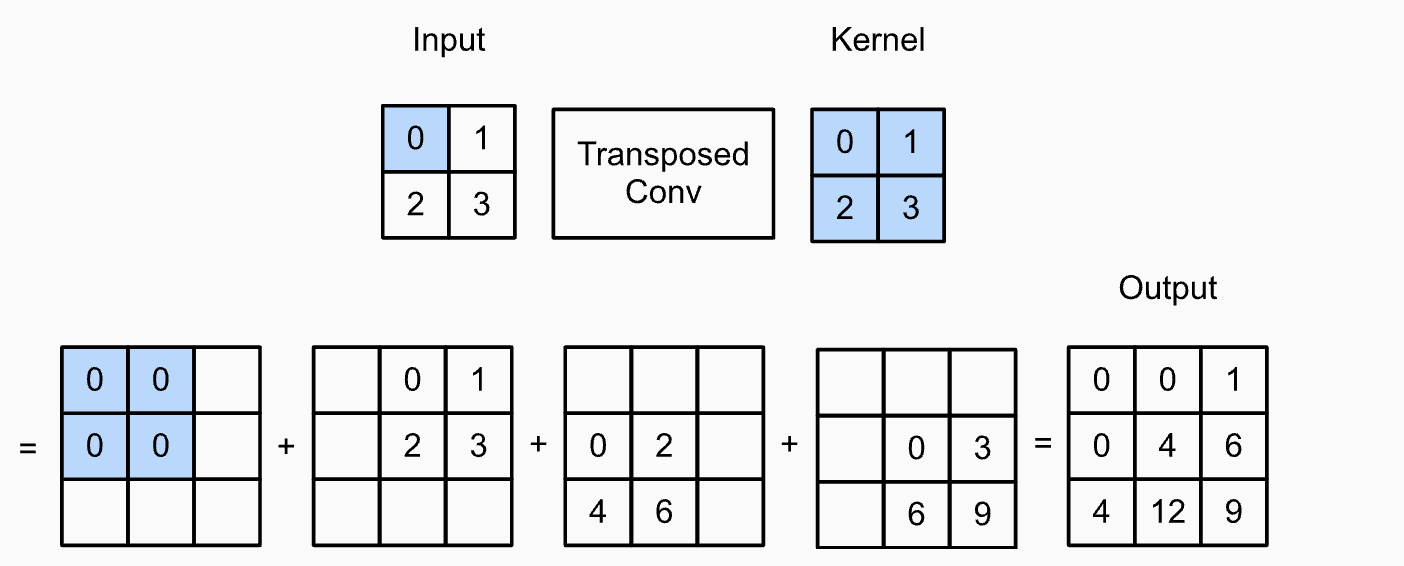

***Transposed Convolution with Stride = 2***
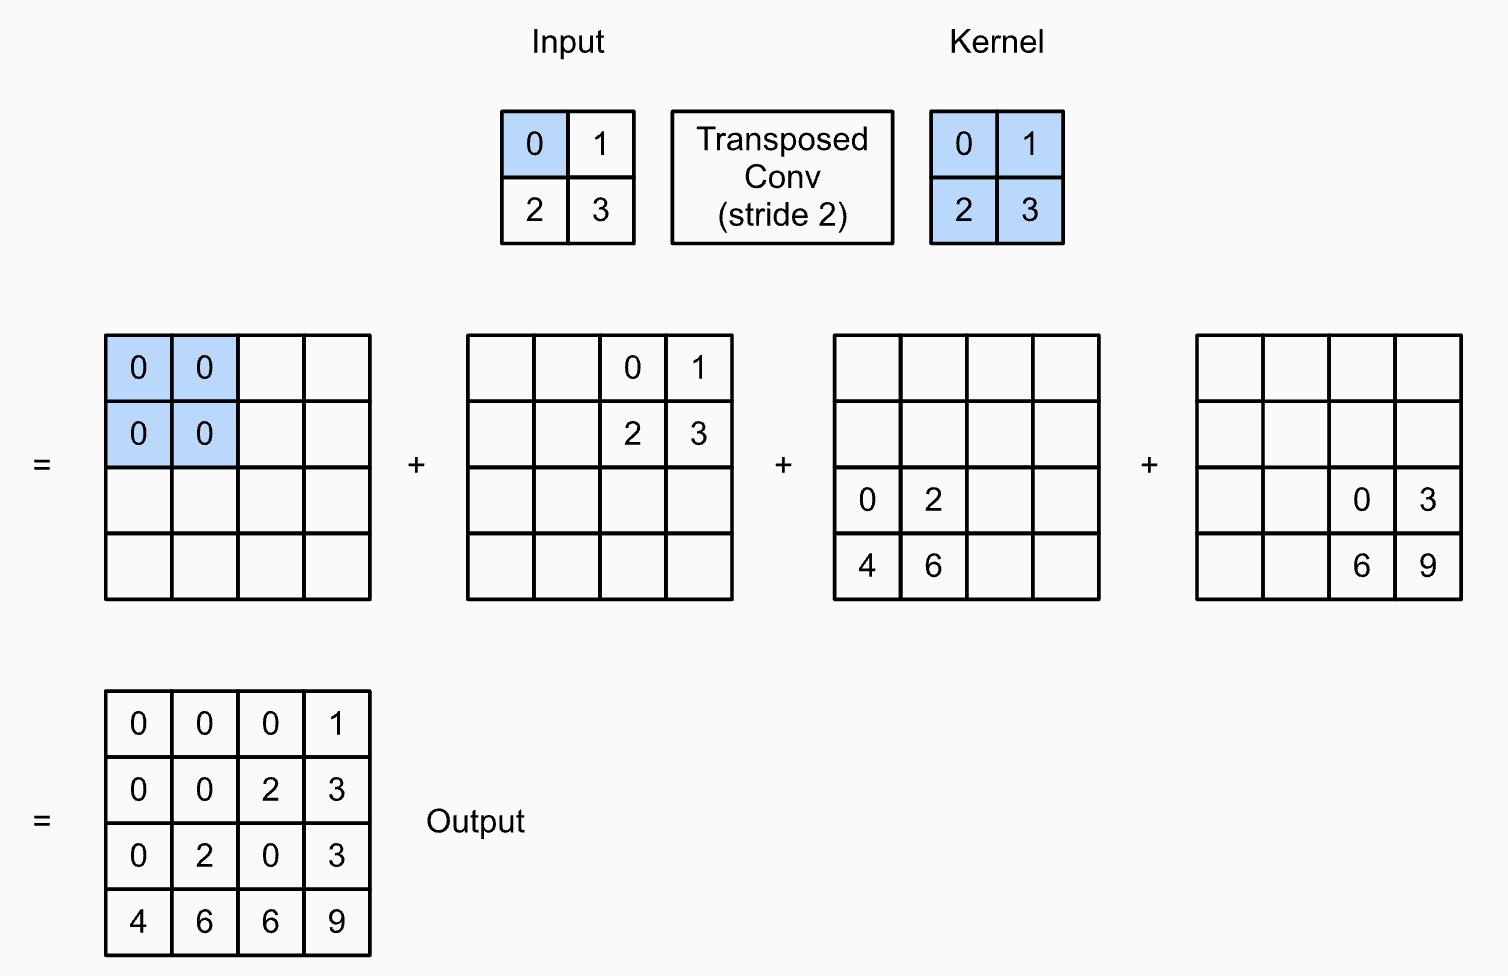

The architecture of your VAE network should be in the following form:


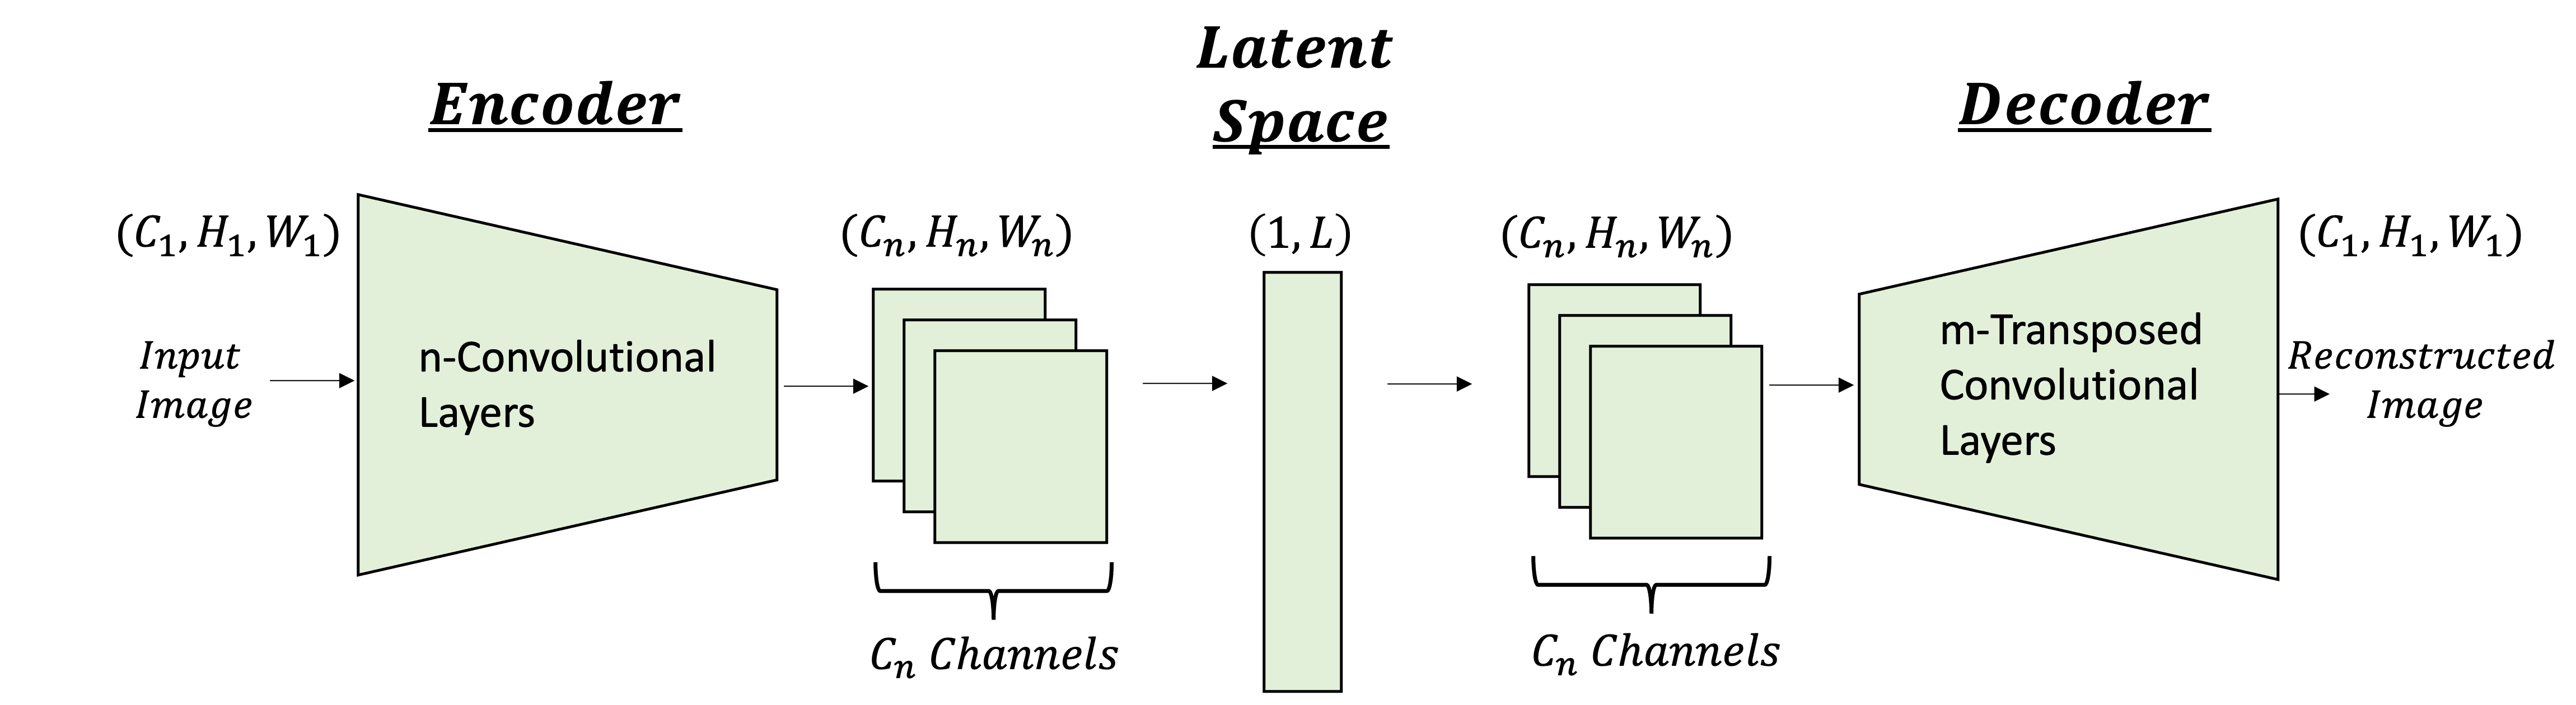

### Part (a) -- 7%

 **Encoder**

Here, you will implement the architecture of the encoder. 

The encoder should consist of 4 Blocks as follows:

BLOCK 1: 
- Convolutional layer (nn.Conv2D(in_channels, num_hidden, kernel_size=(3,3), stride=(2,2)))
- Batch Normalization(num_hidden)
- Activation Function: nn.ReLU()

BLOCK 2: 
- Convolutional layer (nn.Conv2D(num_hidden, num_hidden * 2, kernel_size=(3,3), stride=(2,2))
- Batch Normalization(num_hidden * 2)
- Activation Function: nn.ReLU()

BLOCK 3: 
- Convolutional layer (nn.Conv2D(num_hidden * 2, num_hidden * 4, kernel_size=(3,3), stride=(2,2))
- Batch Normalization(num_hidden * 4)
- Activation Function: nn.ReLU()

BLOCK 4: 
- Convolutional layer (nn.Conv2D(num_hidden * 4, num_hidden * 8, kernel_size=(3,3), stride=(2,2))
- Batch Normalization(num_hidden * 8)
- Activation Function: nn.ReLU()

In addidion to the 4 Blocks, you should add the following linear layers:

Linear $\mu$: 
- nn.Linear( ___ ,latent). 

Linear $\log(\sigma)$: 
- nn.Linear( ___ ,latent).

**NOTES:** 

- The input of the linear layer should be according to the size of the images you picked in the transformation part. (If you did resize the images)

- Consider using Padding in the convolutional layers to correct mismatches in sizes.

- In the forward function, you will have to reshape the output from the 4'th block to $(Batch\cdot H_4\cdot W_4\cdot C_4 , latent)$, where $(Batch$ is the batch size, $H_4$ is the height of the output image from the 4'th block, $W_4$ is the width of the output image from the 4'th block and $C_4$ is num_hidden*8 (number of channels of the output image from the 4'th block).

**You can change any parameter of the network to suit your code - this is only a recommendation.**

In [ ]:
class Encoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, latent):
        super(Encoder, self).__init__()
        # YOUR CODE GOES HERE:

        self.num_hiddens = num_hiddens
        self.latent = latent
        self.block1 = nn.Sequential(nn.Conv2d(in_channels, num_hiddens, kernel_size=(3,3), stride=(2,2),padding=(1,1)),
                                    nn.BatchNorm2d(num_hiddens),
                                    nn.ReLU())
        self.block2 = nn.Sequential(nn.Conv2d(num_hiddens, 2*num_hiddens, kernel_size=(3,3), stride=(2,2),padding=(1,1)),
                                    nn.BatchNorm2d(2*num_hiddens),
                                    nn.ReLU())
        self.block3 = nn.Sequential(nn.Conv2d(2*num_hiddens, 4*num_hiddens, kernel_size=(3,3), stride=(2,2),padding=(1,1)),
                                    nn.BatchNorm2d(4*num_hiddens),
                                    nn.ReLU())
        self.block4 = nn.Sequential(nn.Conv2d(4*num_hiddens, 8*num_hiddens, kernel_size=(3,3), stride=(2,2),padding=(1,1)),
                                    nn.BatchNorm2d(8*num_hiddens),
                                    nn.ReLU())

        # Insert the input size
        self.fc_mu = (nn.Linear(8*num_hiddens*12*14, latent))
        self.fc_logvar = (nn.Linear(8*num_hiddens*12*14, latent))
        

    def forward(self, inputs):
        x = self.block1(inputs)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

**Notice: We output $\log\sigma$ and not $\sigma^2$, this is a convention when training VAEs but it is completely equivalent.**

### Part (b) -- 7%
 **Decoder**

Here, you will implement the architecture of the decoder. 

First, Apply a linear layer to the input of the decoder as follows:

- nn.Linear(latent, ___ ).

The output of the linear layer should match to $Batch\cdot H_4\cdot W_4\cdot C_4$, which were the same parameters from the encoder 4'th block's output.

Then, the decoder should consist of 4 Blocks as follows:

BLOCK 1: 
- Transposed Convolutional layer (nn.ConvTranspose2d(in_channels, num_hidden // 2, kernel_size=(4,4), stride=(2,2)))
- Batch Normalization(num_hidden // 2)
- Activation Function: nn.ReLU() or nn.LeakyReLU()

BLOCK 2: 
- Transposed Convolutional layer (nn.ConvTranspose2d(num_hidden // 2, num_hidden // 4, kernel_size=(4,4), stride=(2,2)))
- Batch Normalization(num_hidden // 4)
- Activation Function: nn.ReLU() or nn.LeakyReLU()

BLOCK 3: 
- Transposed Convolutional layer (nn.ConvTranspose2d(num_hidden // 4, num_hidden // 8, kernel_size=(4,4), stride=(2,2)))
- Batch Normalization(num_hidden // 8)
- Activation Function: nn.ReLU() or nn.LeakyReLU()

BLOCK 4: 
- Transposed Convolutional layer (nn.ConvTranspose2d(num_hidden // 8, num_hidden // 8, kernel_size=(4,4), stride=(2,2)))
- Batch Normalization(num_hidden // 8)
- Activation Function: nn.ReLU() or nn.LeakyReLU()


Afterwards, we should generate an image in the same size as our input images. Thus add 1 more block consisting of:

BLOCK 5:
 - nn.Conv2d(num_hiddens//8, out_channels=3,kernel_size=(3,3), stride=(1,1), padding=(1,1)),
 - Activation function.

**NOTES:** 

- The output of the linear layer should be according to the size of the images you picked in the transformation part. (If you did resize the images)

- Consider using Padding in the  transposed convolutional layers to correct mismatches in sizes.

- In the forward function, you will have to reshape the output of the linear layer to ($Batch, H_4, W_4, C_4$)

- The output of the decoder should be of values in $[0,1]$.



**You can change any parameter of the network to suit your code, this is only a recommendation.**

In [ ]:

class Decoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, latent):
        super(Decoder, self).__init__()
        self.num_hiddens = num_hiddens
        self.fc_dec = nn.Linear(latent, 12*14*num_hiddens)

        self.block1 = nn.Sequential(nn.ConvTranspose2d(in_channels,num_hiddens//2, kernel_size=(4,4),stride=(2,2),padding=(1,1)),
                                    nn.BatchNorm2d(num_hiddens//2),
                                    nn.LeakyReLU())

        self.block2 = nn.Sequential(nn.ConvTranspose2d(num_hiddens//2,num_hiddens//4, kernel_size=(4,4), stride=(2,2),padding=(2,2)),
                                    nn.BatchNorm2d(num_hiddens//4),
                                    nn.LeakyReLU())

        self.block3 = nn.Sequential(nn.ConvTranspose2d(num_hiddens//4,num_hiddens//8, kernel_size=(4,4), stride=(2,2),padding=(0,2)),
                                    nn.BatchNorm2d(num_hiddens//8),
                                    nn.LeakyReLU())

        self.block4 = nn.Sequential(nn.ConvTranspose2d(num_hiddens//8,num_hiddens//8, kernel_size=(4,4), stride=(2,2),padding=(2,2)),
                                    nn.BatchNorm2d(num_hiddens//8),
                                    nn.LeakyReLU())

        self.block5 = nn.Sequential(nn.Conv2d(num_hiddens//8,out_channels=3,kernel_size=(3,3),stride=(1,1),padding=(1,1)),
                                    nn.Sigmoid())

    def forward(self, inputs):
        x = self.fc_dec(inputs)
        x = x.view(x.size(0), self.num_hiddens, 14, 12)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x_rec = self.block5(x)

        return x_rec

### Part (c) -- 4% 
**VAE Model**

Once you have the architecture of the encoder and the decoder, we want to put them together and train the network end-to-end.

Remember that in VAEs, you need to sample from a gaussian distribution at the input of the decoder. In order to backpropagate through the network, we use the reparametrization trick. The reparametrization trick is saying that sampling from $𝑧∼N(\mu,\sigma)$ is equivalent to sampling $\varepsilon∼N(0,1)$ and setting $𝑧=\mu+\sigma⊙\varepsilon$. Where, epsilon is an input to the network while keeping your sampling operation differentiable.
The reparametrization function is given to you in the VAE class.

Here, you should write the *forward()* function and to combine all the model's settings to a final network.

In [ ]:
class VAE(nn.Module):
    def __init__(self, enc_in_chnl,enc_num_hidden,dec_in_chnl,dec_num_hidden,latent):
        super(VAE, self).__init__()
        self.encode = Encoder(in_channels=enc_in_chnl, num_hiddens=enc_num_hidden,latent = latent)
        self.decode = Decoder(in_channels=dec_in_chnl, num_hiddens=dec_num_hidden,latent = latent)
        # for VAE loss - reconstration loss, we will explain there (in the loss function)
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))

    # Reparametrization Trick
    def reparametrize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5*logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu
     
    # Initialize Weights
    def weight_init(self, mean, std):
        for m in self._modules:
            if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
                m.weight.data.normal_(mean, std)
                m.bias.data.zero_()

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        x_rec = self.decode(z)
        return x_rec , mu, logvar


### Part (d) -- 7% 

**Loss Function**

As we saw earlier, the loss function is based on the ELBO; Over a batch in the dataset, it can be written as:

$\mathcal{L(\theta,\phi)} = -\sum_j^J\bigg(\frac{1}{2}\big[1+\log(\sigma_{q_j}^2)-\sigma_{q_j}^2-\mu_{q_j}^2\big]\bigg) - \frac{1}{M}\sum_i^M\bigg(E_{~q_{\theta}(z|x_i)}\big[\log\big(P_{\phi}(x_i|z)\big)\big]\bigg)$

where $J$ is the dimension of the latent vector $z$ and $M$ is the number of samples stochastically drawn from the dataset.

**$\beta$-Variational Autoencoder ($\beta$-VAE)**

As seen in class, the fact that the ELBO is comprised of the sum of two loss terms implies that these can be balanced using an additional hyperparameter $\beta$, i.e.,

$\beta\cdot D_{KL}\big(q(z|x_i)||P(z)\big) - E_{~q(z|x_i)}\big[\log\big(P(x_i|z)\big)\big]$

It is highly recommended to use the $\beta$-loss for increasing performance. 
 


Explain what could be the purpose of the hyperparameter $\beta$ in the loss function? If $\beta = 1$ is same as VAE, What is the effect of $\beta \neq 1$?

In [ ]:
# The hyperparameter β  allows us to balance the two loss terms in the ELBO expression. 

# When β≠1, the relative importance of the reconstruction loss and the regularization term (KL Divergence) changes. 
# If β>1, the model will place more emphasis on the reconstruction loss and less 
# emphasis on the regularization term, which may lead to better reconstructions but 
# potentially less structured latent representations. 
# If β<1, the model will place more emphasis on the regularization term and less 
# emphasis on the reconstruction loss, which may lead to more structured latent 
# representations but potentially worse reconstructions.
# If β=0, the model will only be trained to minimize the reconstruction loss. 
# In this case, the model will be essentially equivalent to a standard autoencoder.0.

Here you should write specifically the code for the loss function.


In [ ]:
# instead of using MSE, we found in this article:
# "https://towardsdatascience.com/variational-autoencoder-demystified-with-pytorch-implementation-3a06bee395ed"
# MAIN IDEA:
# First we need to think of our images as having a distribution in image space.
# Imagine a very high dimensional distribution.
# So, now we need a way to map the z vector (which is low dimensional) back into
# a super high dimensional distribution from which we can measure the probability 
# of seeing this particular image.
# To finalize the calculation of this formula, we use x_hat to parametrize a likelihood 
# distribution (in this case a normal again) so that we can measure the probability 
# of the input (image) under this high dimensional distribution.
# ie: we are asking the same question: Given P_rec(x|z) and this image, what is the probability?
# Since the reconstruction term has a negative sign in front of it, we minimize 
# it by maximizing the probability of this image under P_rec(x|z).

beta = 0.1
#beta=1
def gaussian_likelihood(x_hat, logscale, x):
    scale = torch.exp(logscale)
    mean = x_hat
    dist = torch.distributions.Normal(mean, scale)
    # measure prob of seeing image under p(x|z)
    log_pxz = dist.log_prob(x)
    return log_pxz.sum(dim=(1, 2, 3))

def vae_loss(x_recon, x, mu, logvar,log_scale):
    recon_loss =gaussian_likelihood(x_recon,log_scale,x)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(),dim=-1).mean(dim=0)
    return recon_loss.mean(dim=0), KLD*beta


 Here, define all the hyperparameters values for the training process. 

We gave you recommended values for the VAE model. You can modify and change it to suit your code better if needed.

In [ ]:
learning_rate = 1e-4
batch_size = 200
num_epochs = 60
dataset_size = 30000 # How many data samples to use for training, 30,000 should be enough.
weigth_decay=0
#VAE Class inputs: 
enc_in_chnl = 3
enc_num_hidden = 32
dec_in_chnl = 256
dec_num_hidden = 256

In [ ]:
train_loader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=False) 
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False) 

## Question 5. VAE Training (15 %)



### Part (a) -- 4% 
Complete the training function below

In [ ]:
def train(num_epochs, batch_size, dataset_size, model):
    '''  
    This is a starter code for the training process. You can modify it for your 
    own conveinient.
    num_epochs - number of training epochs
    batch_size - size of the batches
    dataset_size - How many training samples to use. 
    model - The model you are training.   

    Note: decide what are the outputs of the function. 
    '''

    # Your code goes Here:
    #init iteration counter and arrays to save the loss
    n=0
    iters, val_loss ,train_loss = [], [] ,[]
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=weigth_decay) #Adam optimizer
    test_iter=iter(test_loader) #we will use an iterator object to get the next batch for validation

    for epoch in range(num_epochs):
        model.train() #make sure the model is in train mode
        for batch_idx, batch in enumerate(train_loader):
            #load next batch, reset the optimizer grad
            optimizer.zero_grad()
            imgs, _ = batch
            if torch.cuda.is_available():
                imgs = imgs.cuda()
            else:
                imgs = imgs.to(device)
            #forward step
            x_rec, mu, logvar = model(imgs)
            #calculate loss and backward step
            recon_loss,KLD = vae_loss(x_rec, imgs, mu, logvar,model.log_scale)
            loss=KLD-recon_loss
            loss.backward()
            optimizer.step()
            # we face a very long learning time (~60 epochs) we decide not to 
            # check the entire validation set in the end of each epoch- insted,
            # every 10 batches (10*batch_size=2000 images) we save the train loss
            # and check the loss of *ONE* batch from the validion (like SGD but 
            # also on the validation set), we know it less accurate but we didn't
            # manage to get the training in resonable time with the regulare method
            # (i.e check the entire validation set in the end of each epoch)
            if batch_idx %10 == 0:
              #save last batch's loss for training loss
                print("Epoch: {} [{}/{} ({:.0f}%)]\tLoss : {:.6f}".format(
                    epoch, batch_idx * len(imgs), dataset_size,
                    (100*batch_idx * len(imgs)/dataset_size), (float(loss)/ len(imgs))))
                iters.append(n)
                train_loss.append(float(loss)/len(imgs))
                # evaluate on 1 batch from the validtion
                model.eval()
                try:
                  img, _ = next(test_iter)
                except StopIteration:
                  test_iter=iter(test_loader)
                  img, _ = next(test_iter)
                if torch.cuda.is_available():
                  img = img.cuda()
                else:
                  img = img.to(device)
                x_rec, mu, logvar = model(img)
                BCE,KLD = vae_loss(x_rec, img, mu, logvar,model.log_scale)
                loss=KLD-BCE
                val_loss.append(float(loss)/len(img)) 
                print("Validation: [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                   (((epoch*(dataset_size // batch_size)+(batch_idx//10))%len(test_loader)))*batch_size, (len(test_loader)*batch_size),
                  (100*(((batch_idx//10))%len(test_loader))/(len(test_loader))), float(loss) / len(img)))
                model.train()
            #increment iteration counter
            n+=1
            if dataset_size // batch_size == batch_idx:
              #in the end of each epoch, we are saving the model parameters
                    torch.save(model.state_dict(), '/content/gdrive/My Drive/Colab Notebooks/vae_model_NEW_50_B1_E_{}_I_{}.pth'.format(epoch,batch_idx)) 
                   # in addition, we are saving the loss's vectors to aviod
                   # them getting loss when the session crashing, in the plot function,
                   # we are loaded the txt files and plot them as usual
                    with open('/content/gdrive/My Drive/Colab Notebooks/loss_train_50_B1.txt', 'a') as f:
                      # Convert the list to a string and write it to the file
                      f.write('\n')
                      f.write('\n'.join(str(x) for x in train_loss[-1-batch_idx//10:]))
                      f.close()
                    with open('/content/gdrive/My Drive/Colab Notebooks/loss_val_50_B1.txt', 'a') as f:
                      # Convert the list to a string and write it to the file
                      f.write('\n')
                      f.write('\n'.join(str(x) for x in val_loss[-1-batch_idx//10:]))
                      f.close()
                    break

    return model ,(iters, train_loss , val_loss ) 


In [ ]:
def plot_learning_curve(iters, train_loss, val_loss):
    """
    Plot the learning curve.
    If the input not contain the iterations number, we compute them because
    we know that each 10 iteration we save the loss
    """
    if (len(iters)!=len(train_loss)):
      iters=[10*i for i in range(len(train_loss))]
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.plot(iters, train_loss, label="Train")
    ax.plot(iters, val_loss, label="Validation")

    ax.set_title("Learning Curve: Loss per Iteration")
    ax.set_xlabel("Iterations")
    ax.set_ylabel("Loss")
    ax.legend(loc='best')
    plt.show()


### Part (b) -- 4%  

We first train with dimension of latent space $L=3$

We recommend to use *weight_init()* function, which helps stabilize the training process. 

In [ ]:
latent1 = 3

if torch.cuda.is_available():
    model_1 = VAE(enc_in_chnl,enc_num_hidden,dec_in_chnl,dec_num_hidden,latent1).cuda()
    model_1.weight_init(mean=0, std=0.02)
else:
    model_1 = VAE(enc_in_chnl,enc_num_hidden,dec_in_chnl,dec_num_hidden,latent1)
    model_1.weight_init(mean=0, std=0.02)

model_1.load_state_dict(torch.load("/content/gdrive/MyDrive/Colab Notebooks/vae_model_NEW_3_E_9_I_150.pth", map_location=torch.device('cpu')))


<All keys matched successfully>

Train your model, plot the train and the validation loss graphs. Explain what is seen.

In [ ]:
# Your Code Goes Here
model_1 , learning_curve_info =  train(num_epochs,batch_size,dataset_size,model_1)
#this part to load our loss information and then plot them:
with open('/content/gdrive/My Drive/Colab Notebooks/loss_train_3.txt', 'r') as f:
  train_loss = [float(line) for line in f]
  f.close()
with open('/content/gdrive/My Drive/Colab Notebooks/loss_val_3.txt', 'r') as f:
  val_loss = [float(line) for line in f]
  f.close()
plot_learning_curve([1],train_loss,val_loss)

The training loss is decreasing as expected and there is no significant difference between the training and validation losses, indicating that the model is not overfitting or underfitting the data. There is a periodic peak in the validation loss, which may be caused by a batch of data in the test set that is very different from the others. This peak decreases over time, suggesting that the model is able to effectively handle this difficult batch of data. Overall, it appears that the model is performing well.
The Loss graphs for train and validation:
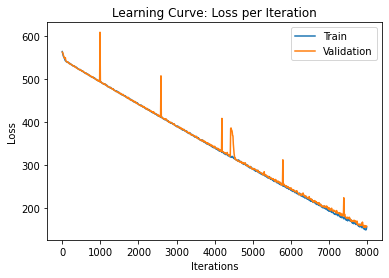

Visualize, from the test dataset, an original image against a reconstructed image. Has the model reconstructed the image successfully? Explain.

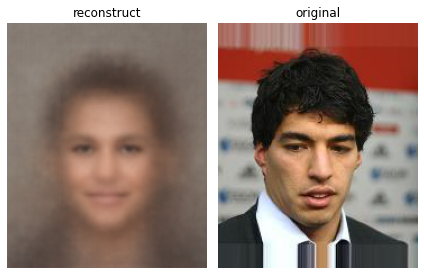

In [ ]:
# Your Code Goes Here
model_1.eval()
#take a batch from the test loader
for i,img in enumerate(test_loader):
  imgs,_ =img 
  if torch.cuda.is_available():
    imgs = imgs.cuda()
  else:
   imgs = imgs.to(device)
  #reconstruct the imgs through our model:
  x_rec=model_1(imgs)
  fig, axes =plt.subplots(1,2)
  #plot the original img next to the reconstruct img:
  axes[0].imshow(x_rec[0].cpu().detach().numpy()[99].transpose(1,2,0))
  axes[0].set_title("reconstruct")
  axes[0].axis("off")
  axes[1].imshow(imgs.cpu().detach().numpy()[99].transpose(1,2,0))
  axes[1].set_title("original")
  axes[1].axis("off")
  plt.tight_layout()
  plt.show()
  break #we only want 1 batch

### Part (c) -- 7%  

Next, we train with larger $L > 3$

Based on the results for $L = 3$, choose a larger $L$ to improve your results.
Train new model with your choice for $L$.

In [ ]:
latent2 = 50

if torch.cuda.is_available():
    model_2 = VAE(enc_in_chnl,enc_num_hidden,dec_in_chnl,dec_num_hidden,latent2).cuda()
    model_2.weight_init(mean=0, std=0.02)
else:
    model_2 = VAE(enc_in_chnl,enc_num_hidden,dec_in_chnl,dec_num_hidden,latent2)
    model_2.weight_init(mean=0, std=0.02)
    
model_2.load_state_dict(torch.load("/content/gdrive/My Drive/Colab Notebooks/vae_model_NEW_50_B1_E_59_I_150.pth", map_location=torch.device('cpu')))


<All keys matched successfully>

Plot the train and the validation loss graphs. Explain what is seen.

Epoch: 0 [0/30000 (0%)]	Loss : 562.923398
Validation: [0/20000 (0%)]	Loss: 562.929219
Epoch: 0 [2000/30000 (7%)]	Loss : 559.325664
Validation: [200/20000 (1%)]	Loss: 561.412734
Epoch: 0 [4000/30000 (13%)]	Loss : 554.665859
Validation: [400/20000 (2%)]	Loss: 561.031523
Epoch: 0 [6000/30000 (20%)]	Loss : 550.130234
Validation: [600/20000 (3%)]	Loss: 556.518633
Epoch: 0 [8000/30000 (27%)]	Loss : 547.549531
Validation: [800/20000 (4%)]	Loss: 547.462422
Epoch: 0 [10000/30000 (33%)]	Loss : 545.299766
Validation: [1000/20000 (5%)]	Loss: 544.719180
Epoch: 0 [12000/30000 (40%)]	Loss : 543.412773
Validation: [1200/20000 (6%)]	Loss: 542.989219
Epoch: 0 [14000/30000 (47%)]	Loss : 540.750547
Validation: [1400/20000 (7%)]	Loss: 540.784258
Epoch: 0 [16000/30000 (53%)]	Loss : 539.462773
Validation: [1600/20000 (8%)]	Loss: 539.614687
Epoch: 0 [18000/30000 (60%)]	Loss : 538.345937
Validation: [1800/20000 (9%)]	Loss: 538.070234
Epoch: 0 [20000/30000 (67%)]	Loss : 537.471875
Validation: [2000/20000 (10%)]

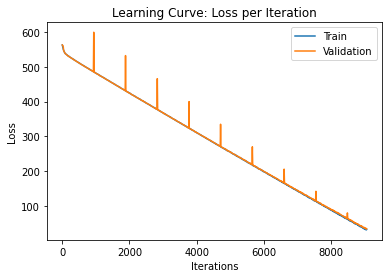

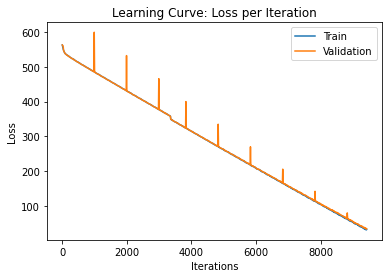

In [ ]:
model_2 , learning_curve_info =  train(num_epochs,batch_size,dataset_size,model_2)
plot_learning_curve(*learning_curve_info)
with open('/content/gdrive/My Drive/Colab Notebooks/loss_train_50_B1.txt', 'r') as f:
  train_loss = [float(line) for line in f]
  f.close()
with open('/content/gdrive/My Drive/Colab Notebooks/loss_val_50_B1.txt', 'r') as f:
  val_loss = [float(line) for line in f]
  f.close()
plot_learning_curve([1],train_loss,val_loss)

The training loss in the model with a latent size of 50 exhibits a monotonic decrease, as expected. Comparison of the training and validation losses reveals no significant difference, implying that the model is neither overfitting nor underfitting the data. An examination of the validation loss reveals a periodic peak, which appears more frequently in the latent size 50 model compared to the model with a latent size of 3. However, this peak exhibits a smoother decrease in the latent size 50 model, indicating that the model is more adept at effectively handling this particular batch of data. Based on these observations, it can be concluded that the model with a latent size of 50 is performing effectively.

The Loss graphs for train and validation:


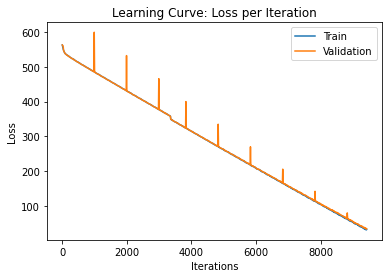

Visualize, from the test dataset, an original image against a reconstructed image. Has the model reconstructed the image successfully? Are the images identical? Explain.

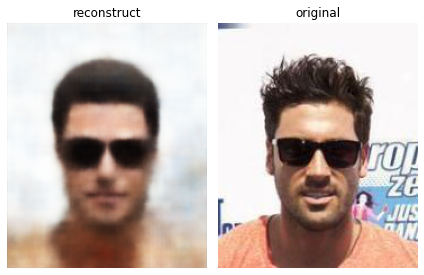

In [ ]:
# Your Code Goes Here
model_2.eval()
for i,img in enumerate(test_loader):
  imgs,_ =img
  if torch.cuda.is_available():
   imgs = imgs.cuda()
  else:
   imgs = imgs.to(device)
  x_rec=model_2(imgs)
  fig, axes =plt.subplots(1,2)
  axes[0].imshow(x_rec[0].cpu().detach().numpy()[9].transpose(1,2,0))
  axes[0].set_title("reconstruct")
  axes[0].axis("off")
  axes[1].imshow(imgs.cpu().detach().numpy()[9].transpose(1,2,0))
  axes[1].set_title("original")
  axes[1].axis("off")
  plt.tight_layout()
  plt.show()
  break


 What will happened if we choose extremely high dimension for the latent space?

In [ ]:
# Write your explanation here
#If we choose an extremely high dimension for the latent space in a compression task, 
# it will result in a more accurate reconstruction of the original data but will 
# also cost more in terms of training time. This is because a lower bound to lossless 
# compression is the entropy of the data, and by compressing an image from a high 
# dimension to a much lower dimension, we are breaking this lower bound. As we 
# increase the latent space, we can improve the performance of the model by getting
# closer to the real distribution of the data. However, the larger the latent space, 
# the longer it will take for the model to achieve good performance.

# We can see that in the model with a latent size of 3, all of the reconstructed
# images appear to be of females with simple details. However, in the model with
# a latent size of 50, the model is able to reconstruct images of both males and
# females with more detailed features such as sunglasses and distinct colors.
# This suggests that the model with a latent size of 50 is performing better
# at reconstructing images.

 
Did you output blurry reconstructed images? If the answer is yes, explain what could be the reason. If you got sharp edges and fine details, explain what you did in order to achieve that. 

Note: If you got blurry reconstructed images, just explain why. You dont need to change your code or retrain your model for better results (as long as your results can be interpreted as a human face).
 

In [ ]:
# The model tries to reconstruct human faces by mapping features from the latent
# space onto the image using the decoder network. However, if the latent space is
# smaller, it represents a lower-dimensional representation of the data and some
# information is lost. This can cause the reconstructed image to be less defined,
# less sharp, and have fewer details, resulting in blurry generalizations of
# human faces. On the other hand, if the latent space is larger, more detailed
# information is retained, leading to clearer and more defined reconstructions
# of human faces.

## Question 6: Generate New Faces (10 %)

Now, for the fun part!

We are going to generate new celebrity faces with our VAE models. A function for new faces generation is given to you. Modify it (if needed) to fit your code. 



In [ ]:
# we decide to used different version of the show() function and not the one from part a
def show(imgs):
    plt.figure(figsize=(8,16))
    for idx,celeb in enumerate(imgs):
      plt.subplot(8, 4, idx+1)
      plt.axis('off')
      plt.imshow(celeb)
    plt.tight_layout()
    return None

In [ ]:
def generate_faces(model, grid_size, latent):
    model.eval()
    dummy = torch.empty([grid_size,latent])
    z = torch.randn_like(dummy).to(device)
    #we notic that our latent space still dosen't look like Z~N(0,1) so we
    # multiply with random integer to get better resulte
    if latent==3:
      for i in range(grid_size):
        noise=random.randint(5,10)
        z[i]=noise*z[i]
    if latent==50:
      for i in range(grid_size):
        noise=random.randint(1,3)
        z[i]=noise*z[i]+noise/2
    sample = model.decode(z)
    new_face_list = []

    j=0
    while j < grid_size: 
        new_face_list.append(sample[j].cpu().detach().numpy().transpose(1,2,0))
        j+=1

    show(new_face_list)


**Model 1 ($L = 3$) results:**

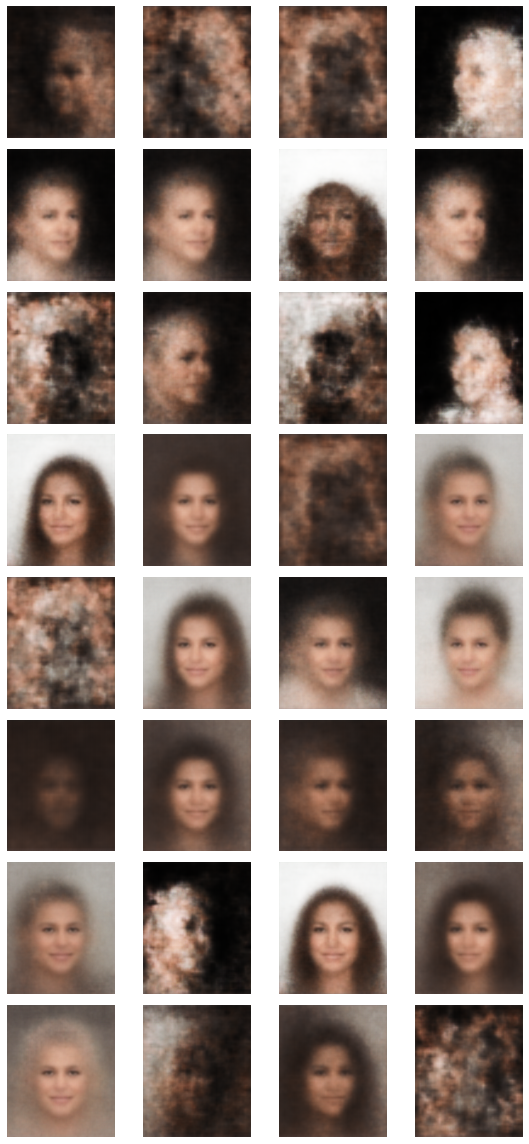

In [ ]:
generate_faces(model_1,grid_size=32,latent=3)



****



**Model 2 results:**

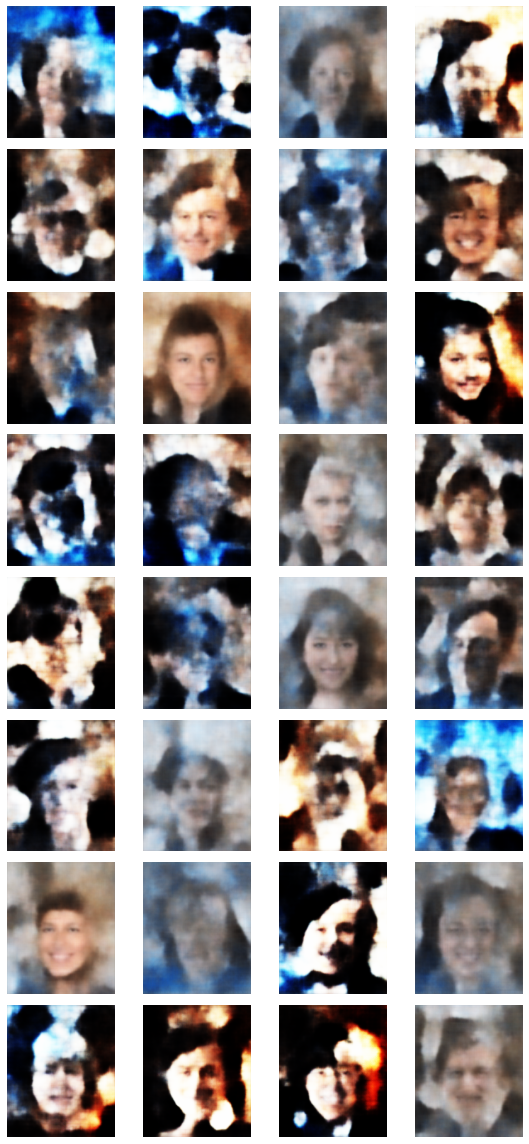

In [ ]:
generate_faces(model_2,grid_size=32,latent=50)



*******
*Q1:* Generate new faces with VAE model with latent space dimension = 3. Did you get diverse results? What are the most prominent features that the latent space capture? 

*Q2:* Generate new faces with VAE model with your decision for latent space dimension. What are the most prominent features that the latent space capture? 

*Q3:* What are the differences? Your results are similar to the dataset images? Do you get realistic images for your chosen latent space dimension? If not, change your decision or your network to acheive more realistic results.

In [ ]:
#YOUR ANSWERS GOES HERE

# Q1 Answer: 
# The results were somewhat diverse.
# There all look like woman, the prominent features we notic: 
# positioning of the face, hair style, and background color.
# Q2 Answer: 
# The results were very diverse.
# Some look like man and some like women, the prominent features we notic: 
# positioning of the face, hair style, background color, beard style,
# mouth style (smile, teeth...), clothes.
# Q3 Answer: 
# There are significant differences between the results of latent 3 and latent 50.
# Latent 3 produces images that are more similar to a doll in a 1940s shop, while 
# latent 50 produces more realistic images, although not all of them resemble real
# people (even after full 60 epochs of training, that is we belive because it take
# alot of time get close to P(z) with high deminstion).
# When comparing the generated images to the dataset, there is some similarity
# with those produced by latent 50, but none with latent 3. The resolution of the
# images is not high, but it is clear that latent 50 produces more realistic results.

## Question 7: Extrapolation (10 %)

Recall that we extrapolate in the images domain in Question 2, part (c).
Here, extrapolate in the latent space domain to generate new images.

Define $\beta = [0, 0.1, 0.2, ... , 0.9, 1]$ and randomly sample from $Z \sim \mathcal{N(0,1)}$ 2 different samples and generate 2 new face images: $X_1, X_2$.

Extrapolate in the latent domain as follows: $\beta_i\cdot Z_1 + (1-\beta_i)\cdot Z_2$ for each $\beta_i \in \beta$.

Plot the extrapolation of the images for each $\beta$ and discuss your results. 
Repeat the process for 3 different samples.



In [ ]:
# YOUR CODE GOES HERE
beta=[i/10 for i in range(11)]
model_1.eval()
for i in range(3):
  #get random sample from latent space and add some noise
  dummy1 = torch.empty([1,3])
  noise1=random.randint(5,10)
  z1 = noise1*torch.randn_like(dummy1).to(device)
  dummy2 = torch.empty([1,3])
  noise2=random.randint(5,10)
  z2 = noise2*torch.randn_like(dummy2).to(device)
  # decode z1 and z2 to get x1 and x2
  pic1=model_1.decode(z1)
  pic2=model_1.decode(z2)
  fig, axes =plt.subplots(1,2)
  axes[0].imshow(pic1.cpu().detach().numpy()[0].transpose(1,2,0))
  axes[0].set_title("original_1")
  axes[0].axis("off")
  axes[1].imshow(pic2.cpu().detach().numpy()[0].transpose(1,2,0))
  axes[1].set_title("original_2")
  axes[1].axis("off")
  plt.tight_layout()
  plt.show()
  plt.figure(figsize=(10, 4)) 
  #for each beta, calculate b*z1+(1-b)*z2 and decode to get new image
  for a in range(10):
    plt.subplot(2, 5, a+1)
    sample=model_1.decode(beta[a]*z1+(1-beta[a])*z2)
    plt.imshow(sample[0].cpu().permute(1,2,0).detach().numpy())
    plt.axis('off')
  plt.show()


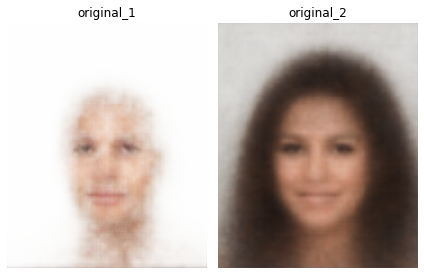

We can see very nice and smoothly proccess of a woman that loss her hair, and even the "original_1" dosent look real, the 6 figure (counting from up left to rigth) look like a man!

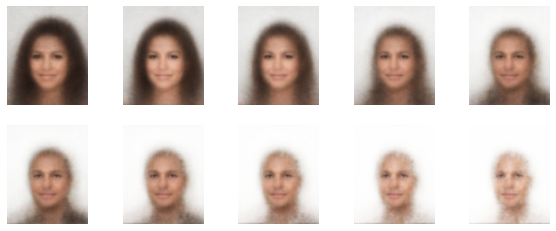

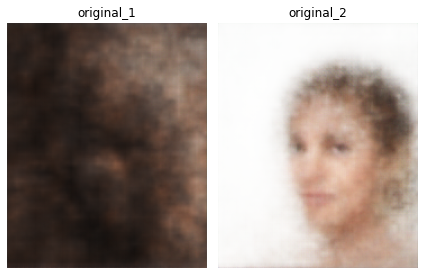

even the origin figures dosen't look very good, the interpolation plot  some real looking people and the transforamtion is very nicely

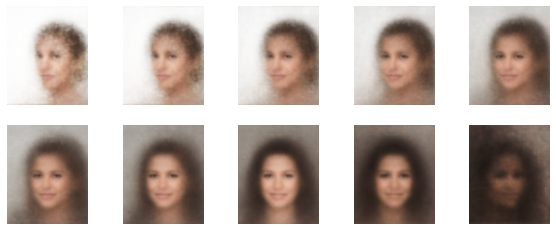

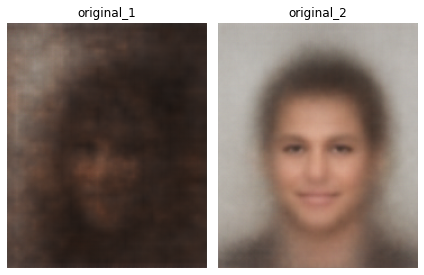

A man becoming a woman :)

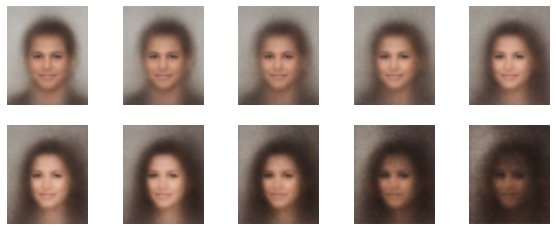

In [ ]:
beta=[i/10 for i in range(11)]
model_2.eval()
for i in range(20):
  dummy1 = torch.empty([1,50])
  noise1=random.randint(1,3)
  z1 = noise1*torch.randn_like(dummy1).to(device)+noise1/2
  dummy2 = torch.empty([1,50])
  noise2=random.randint(1,3)
  z2 = noise2*torch.randn_like(dummy2).to(device)+noise2/2
  pic1=model_2.decode(z1)
  pic2=model_2.decode(z2)
  fig, axes =plt.subplots(1,2)
  axes[0].imshow(pic1.cpu().detach().numpy()[0].transpose(1,2,0))
  axes[0].set_title("original_1")
  axes[0].axis("off")
  axes[1].imshow(pic2.cpu().detach().numpy()[0].transpose(1,2,0))
  axes[1].set_title("original_2")
  axes[1].axis("off")
  plt.tight_layout()
  plt.show()
  plt.figure(figsize=(10, 4)) 
  for a in range(10):
    plt.subplot(2, 5, a+1)
    sample=model_2.decode(beta[a]*z1+(1-beta[a])*z2)
    plt.imshow(sample[0].cpu().permute(1,2,0).detach().numpy())
    plt.axis('off')
  plt.show()


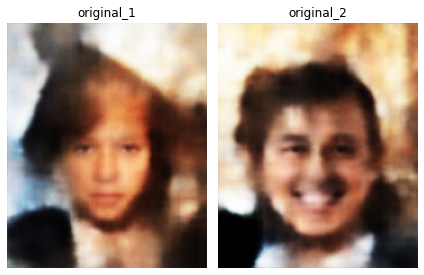


We can see a young boy transforming to an adult man :)

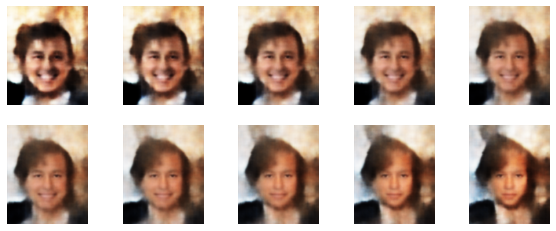

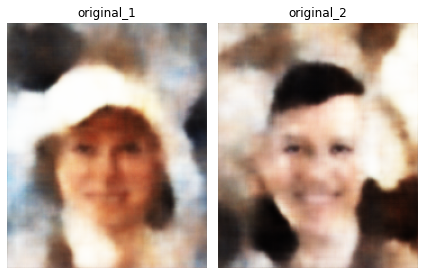

look like a man with yarmulka transfrom to a woman with white hat

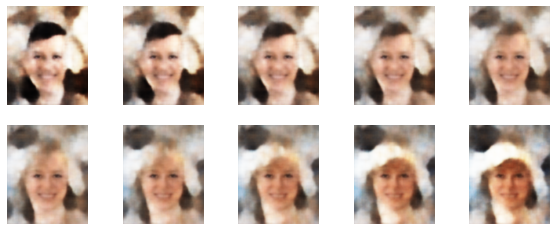

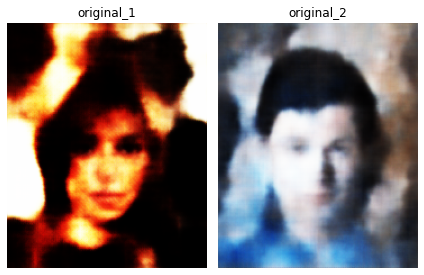

Again, look like a man that transfroming to a woman, the 5'th figure look even better than the last one!

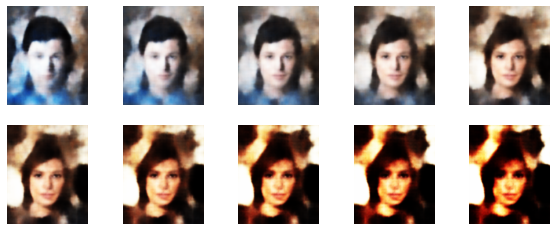

**In summary**, there is a significant difference between extrapolating in Q2.c, which appears to be two concrete faces facing each other with varying transparency levels, and extrapolating in the latent space. The results obtained are very interesting, as even though the original figures X1 and X2 may not appear realistic, some steps of extrapolation in the latent space result in more realistic images. Additionally, there is a smooth transformation between the two sides (beta=0 and beta=1). From these results, it can be concluded that extrapolating in the latent space has meaning and that it is possible to generate many new samples that are, in some cases, even better than those generated by simply generating Z in Q6.